Import dependencies 

In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, RepeatVector, Reshape, Concatenate, UpSampling2D
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

adding dataset and directory markup for test, train

In [2]:
classes = ["de", "en", "es"]
label = np.array([1, 0, 0])
files = []
y = []
for cls in classes:
    path = '../input/spoken-languages/train/' + cls + '/'
    names = os.listdir(path)
    for pos in range(len(names)):
        files.append(path + names[pos])
        y.append(label)
    label = np.roll(label, 1)

files = np.array(files)
y = np.array(y)
paths_train, paths_valid, y_train, y_valid = train_test_split(files, y, test_size = 0.2, random_state=45)
print(paths_train.shape, y_train.shape, paths_valid.shape, y_valid.shape)

(48000,) (48000, 3) (12000,) (12000, 3)


In [3]:
def batch_generator(for_train, batch_size):
    while True:
        if for_train is True:
            idx = np.random.randint(0, paths_train.shape[0], batch_size)
        else:
            idx = np.random.randint(0, paths_valid.shape[0], batch_size)
            
        x = np.zeros((batch_size, 39, 1001, 1))
        y = np.zeros((batch_size, 3))
        for i in range(batch_size):
            if for_train is True:
                audio, sr = librosa.load(paths_train[idx[i]], sr=16000)
                y[i] = y_train[idx[i]]
            else:
                audio, sr = librosa.load(paths_valid[idx[i]], sr=16000)
                y[i] = y_valid[idx[i]]
            #extracting features for audio data through melspectogram    
            mfcc = librosa.feature.mfcc(audio, sr=sr, n_mfcc=40, hop_length=int(0.010*sr), n_fft=int(0.025*sr))
            if mfcc.shape[1] < 1001:
                mfcc = np.concatenate((mfcc, np.zeros((mfcc.shape[0], 1001-mfcc.shape[1]))), axis=1)
            else:
                mfcc = mfcc[:, 0:1001]
            x[i, :, :, 0] = mfcc[1:]
            
        yield x, y

In [4]:
input = Input(shape=(39, 1001, 1))

In [5]:
temp = Conv2D(24, (6, 6), activation='relu')(input)
temp = AveragePooling2D((2,2))(temp)
temp = Conv2D(24, (6, 6), activation='relu')(temp)
temp = AveragePooling2D((2,2))(temp)
temp = Conv2D(24, (6, 6), activation='relu')(temp)
temp = AveragePooling2D((1,141))(temp)
output = Dense((3), activation='softmax')(temp)
output = Reshape((3,))(output)
print(output)

Tensor("reshape_1/Reshape:0", shape=(?, 3), dtype=float32)


In [6]:
model = Model(inputs=input, outputs=output)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [7]:
train_gen = batch_generator(True, batch_size=32)
valid_gen = batch_generator(False, batch_size=32)

In [8]:
history=model.fit_generator(generator=train_gen,
    epochs=5,
    steps_per_epoch=paths_train.shape[0] // 32,
    validation_data=valid_gen,
    validation_steps=paths_valid.shape[0] // 32)


Epoch 1/5
1500/1500 [==============================] - 1175s 783ms/step - loss: 0.7762 - acc: 0.6282 - val_loss: 0.4516 - val_acc: 0.8119
Epoch 2/5
1500/1500 [==============================] - 1065s 710ms/step - loss: 0.3506 - acc: 0.8596 - val_loss: 0.2423 - val_acc: 0.9088
Epoch 3/5
1500/1500 [==============================] - 1035s 690ms/step - loss: 0.2271 - acc: 0.9144 - val_loss: 0.1680 - val_acc: 0.9367
Epoch 4/5
1500/1500 [==============================] - 1029s 686ms/step - loss: 0.1578 - acc: 0.9405 - val_loss: 0.1846 - val_acc: 0.9298
Epoch 5/5
1500/1500 [==============================] - 1037s 692ms/step - loss: 0.1308 - acc: 0.9510 - val_loss: 0.1283 - val_acc: 0.9502


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 39, 1001, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 996, 24)       888       
_________________________________________________________________
average_pooling2d_1 (Average (None, 17, 498, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 493, 24)       20760     
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 246, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 241, 24)        20760     
_________________________________________________________________
average_pooling2d_3 (Average (None, 1, 1, 24)          0         
__________

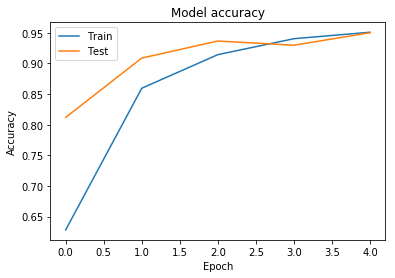

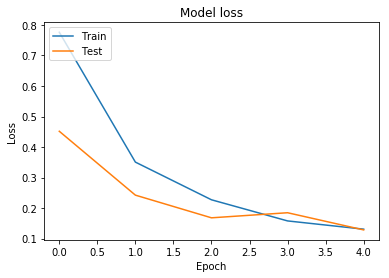

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

check accuracy of the model

print(model.evaluate_generator(generator=valid_gen,steps=paths_valid.shape[0] // 32)[1]*100)

In [12]:
print(model.evaluate_generator(generator=valid_gen,steps=paths_valid.shape[0] // 32)[1]*100)

95.25833333333334
